In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
from scipy.stats import zscore
from IPython.display import display
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [7]:
# df = pd.read_csv(Path('../data/2023basketballsheet.csv'), index_col=1)[lambda df_: df_["R#"] < 120]
df = (
    pd.read_csv(Path('../catsketball/staticdata/2023hashtagbasketballprojections.csv'), index_col=2)
    [lambda df_: df_["R#"] < 150]
    .sort_values("ADP")
    .assign(pick=lambda df_: df_["ADP"].rank())
    # .sort_values("R#")
    # .assign(pick=lambda df_: df_["R#"].rank())
)

STAT_COLS = ["FG%", "FT%", "3pm", "PTS", "TREB", "AST", "STL", "BLK", "TO"]
POSITIONS = ["PG", "SG", "SF", "PF", "C"]

In [100]:
df.head()

,R#,ADP,POS,TEAM,GP,MPG,FG%,FT%,3pm,PTS,TREB,AST,STL,BLK,TO,TOTAL,pick
PLAYER,,,,,,,,,,,,,,,,,
Nikola Jokic,1,1.1,C,DEN,72,33.6,0.624(9.2/14.8),0.821(5.0/6.1),1.0,24.5,11.7,9.7,1.4,0.7,3.7,14.71,1.0
Joel Embiid,2,2.9,C,PHI,67,34.2,0.537(10.8/20.0),0.836(9.9/11.9),1.2,32.6,10.2,4.2,1.1,1.6,3.3,13.81,2.5
Luka Doncic,6,2.9,PG,DAL,66,35.8,0.492(11.0/22.4),0.761(7.8/10.2),3.0,32.7,8.8,8.1,1.3,0.5,3.6,9.86,2.5
Jayson Tatum,5,4.7,"SF,PF",BOS,75,36.5,0.466(9.8/21.0),0.858(6.6/7.7),3.3,29.5,8.2,4.8,1.1,0.7,3.0,9.92,4.0
Tyrese Haliburton,4,5.9,"PG,SG",IND,73,34.7,0.488(9.0/18.4),0.857(2.6/3.0),2.8,23.3,4.0,10.5,1.7,0.4,2.6,10.00,5.0


In [101]:
def format_percentages(val):
    left_paren = val.index("(")
    right_paren = val.index(")")
    slash = val.index("/")
    makes = float(val[left_paren+1:slash])
    attempts = float(val[slash+1: right_paren])
    return pd.Series([makes, attempts])

def clean_df(df):
    df[["FGM", "FGA"]] = df["FG%"].apply(format_percentages)
    df[["FTM", "FTA"]] = df["FT%"].apply(format_percentages)   
    df["TO"] = -1 * df["TO"]
    # positions = df["POS"].apply(encode_positions)
    # df = df.merge(positions, left_index=True, right_index=True)
    return df

df = df.pipe(clean_df)

/tmp/ipykernel_1817/35473986.py:10: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df[["FGM", "FGA"]] = df["FG%"].apply(format_percentages)
/tmp/ipykernel_1817/35473986.py:11: FutureWarning: Returning a DataFrame from Series.apply when the supplied function returns a Series is deprecated and will be removed in a future version.
  df[["FTM", "FTA"]] = df["FT%"].apply(format_percentages)


In [102]:
scoring = {
    "TREB": 1,
    "STL": 4,
    "BLK": 4,
    "AST": 2,
    "FGM": 2,
    "FGA": -1,
    "FTM": 1,
    "FTA": -1,
    "3pm": 1,
    "PTS": 1,
    "TO": -1
}
reb_value = 1
stl_value = 4
blk_value = 4
ast_value = 2
point_projections = df.copy()
for stat, value in scoring.items():
    point_projections[stat] = point_projections[stat]*value

Text(0, 0.5, 'Expected points')

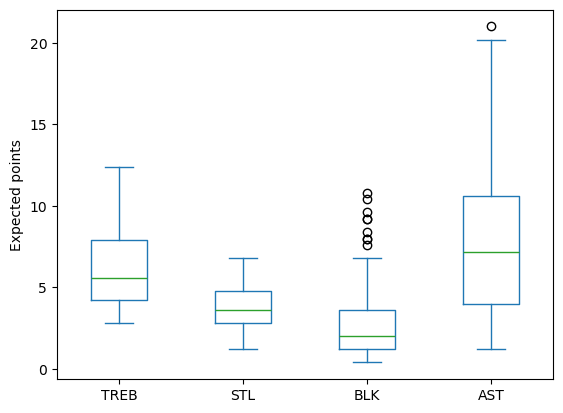

In [103]:
ax = point_projections[["TREB", "STL", "BLK", "AST"]].plot.box()
ax.set_ylabel("Expected points")

In [104]:
point_projections[["3pm", "PTS", "AST", "TREB", "STL", "BLK", "TO", "FGM", "FGA", "FTM", "FTA"]].corr()

,3pm,PTS,AST,TREB,STL,BLK,TO,FGM,FGA,FTM,FTA
3pm,1.000000,0.501789,0.317799,-0.532776,0.125010,-0.507183,0.267098,0.399177,-0.609614,0.188978,-0.092298
PTS,0.501789,1.000000,0.510706,0.047584,0.102558,-0.204476,0.737855,0.974434,-0.957284,0.848635,-0.818144
AST,0.317799,0.510706,1.000000,-0.227483,0.432906,-0.487573,0.732367,0.482440,-0.546741,0.433644,-0.392615
TREB,-0.532776,0.047584,-0.227483,1.000000,-0.311849,0.576975,0.118515,0.144454,0.083249,0.143746,-0.250057
STL,0.125010,0.102558,0.432906,-0.311849,1.000000,-0.323191,0.205223,0.083579,-0.157797,0.085017,-0.060075
BLK,-0.507183,-0.204476,-0.487573,0.576975,-0.323191,1.000000,-0.248738,-0.144835,0.313931,-0.057359,-0.021861
TO,0.267098,0.737855,0.732367,0.118515,0.205223,-0.248738,1.000000,0.720889,-0.716476,0.681601,-0.677183
FGM,0.399177,0.974434,0.482440,0.144454,0.083579,-0.144835,0.720889,1.000000,-0.946105,0.765584,-0.752703
FGA,-0.609614,-0.957284,-0.546741,0.083249,-0.157797,0.313931,-0.716476,-0.946105,1.000000,-0.705733,0.661094
FTM,0.188978,0.848635,0.433644,0.143746,0.085017,-0.057359,0.681601,0.765584,-0.705733,1.000000,-0.983495


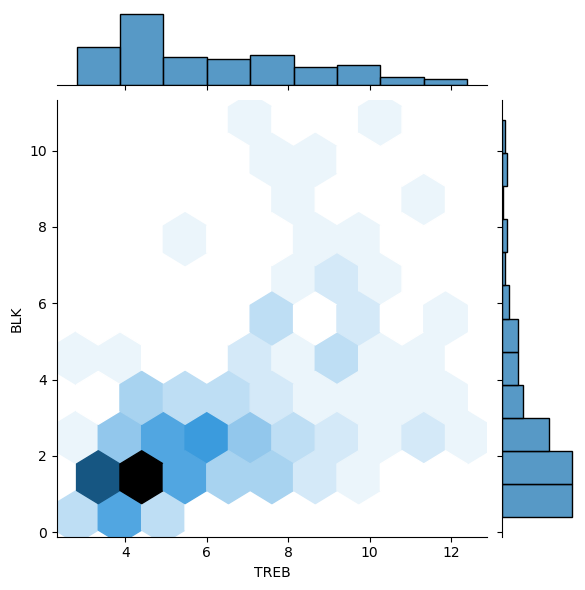

In [105]:
sns.jointplot(data=point_projections, x="TREB", y="BLK", kind="hex")

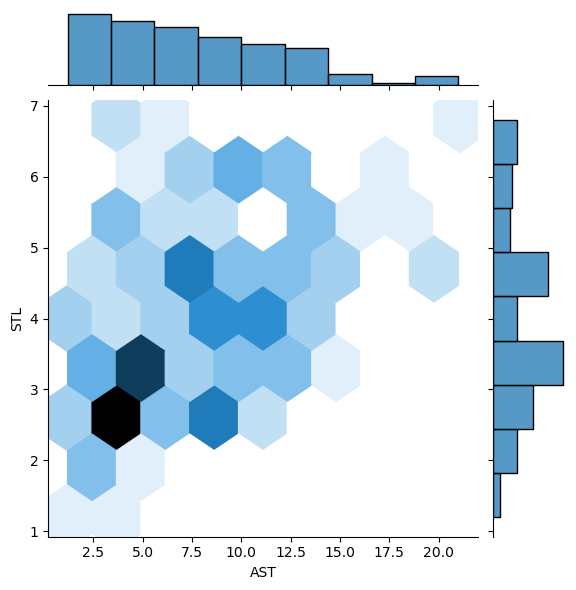

In [106]:
sns.jointplot(data=point_projections, x="AST", y="STL", kind="hex")

In [107]:
point_projections["TREB+BLK"] = point_projections["TREB"] + point_projections["BLK"]
point_projections["STL+AST"] = point_projections["STL"] + point_projections["AST"]

Text(0, 0.5, 'Expected points')

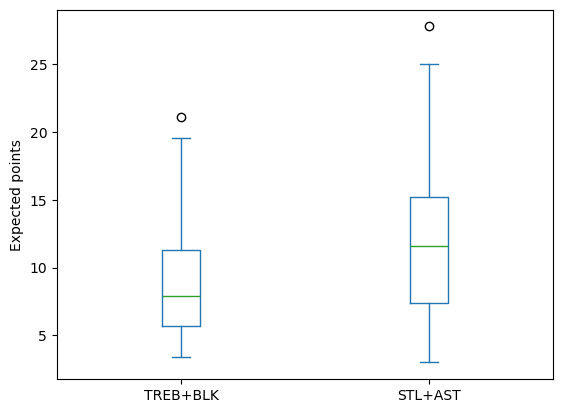

In [108]:
ax = point_projections[["TREB+BLK", "STL+AST"]].plot.box()
ax.set_ylabel("Expected points")

In [109]:
point_projections["total"] = point_projections[list(scoring.keys())].sum(axis=1)
point_projections["guard_pts"] = point_projections["total"] - point_projections["TREB+BLK"]
point_projections["big_pts"] = point_projections["total"] - point_projections["STL+AST"]

Text(0, 0.5, 'Expected points')

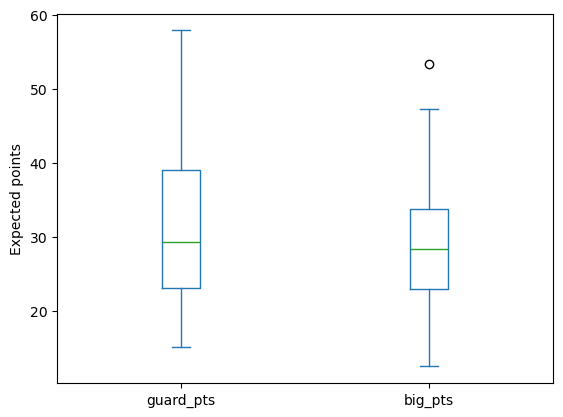

In [110]:
ax = point_projections[["guard_pts", "big_pts"]].plot.box()
ax.set_ylabel("Expected points")

<Axes: xlabel='POS', ylabel='points'>

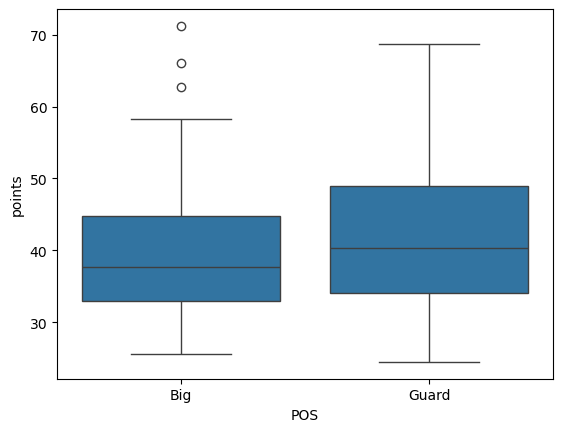

In [125]:
bigs = point_projections[point_projections["POS"].str.contains(r"C|PF")]
guards = point_projections[point_projections["POS"].str.contains(r"SG|PG")]
combined = pd.concat([
    pd.DataFrame({
        "POS": "Big",
        "points": bigs["total"],
        "rank": bigs["R#"],
    }),
    pd.DataFrame({
        "POS": "Guard",
        "points": guards["total"],
        "rank": guards["R#"]
    })
])
sns.boxplot(data=combined, x="POS", y="points")

<Axes: xlabel='POS', ylabel='points'>

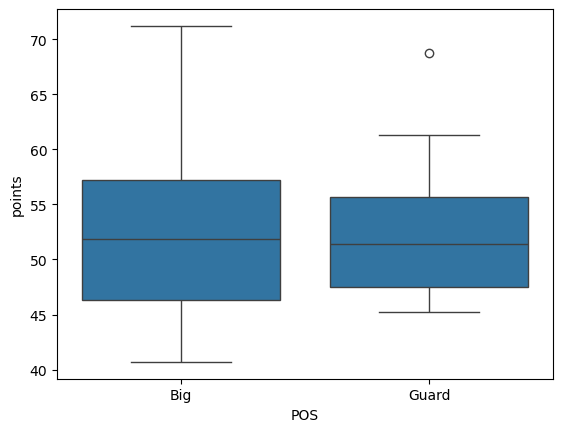

In [126]:
sns.boxplot(data=combined[combined["rank"] < 40], x="POS", y="points")

<Axes: xlabel='POS', ylabel='points'>

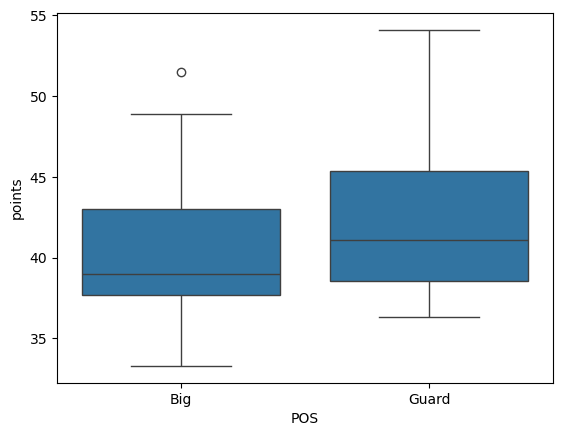

In [127]:
sns.boxplot(data=combined[(combined["rank"] > 40) & (combined["rank"] < 80)], x="POS", y="points")

<Axes: xlabel='POS', ylabel='points'>

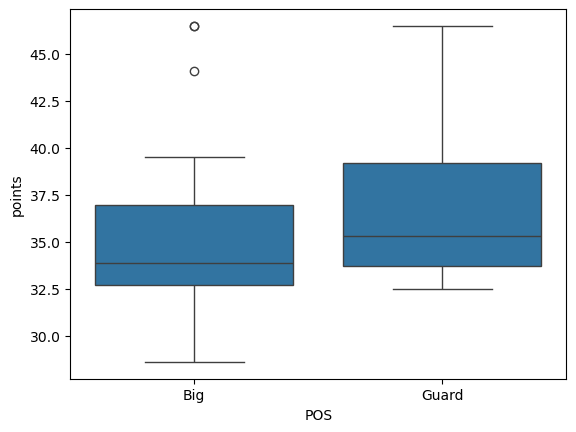

In [128]:
sns.boxplot(data=combined[(combined["rank"] > 80) & (combined["rank"] < 120)], x="POS", y="points")

In [6]:
realgm = pd.read_html("https://basketball.realgm.com/nba/stats/2023/Averages/Qualified/points/All/desc/1/Regular_Season")[0]

In [10]:
realgm = realgm.merge(df[["POS"]], left_on="Player", right_index=True)

In [12]:
realgm.columns

Index(['#', 'Player', 'Team', 'GP', 'MPG', 'PPG', 'FGM', 'FGA', 'FG%', '3PM',
       '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'ORB', 'DRB', 'RPG', 'APG', 'SPG',
       'BPG', 'TOV', 'PF', 'POS'],
      dtype='object')

In [13]:
realgm["FGMI"] = realgm["FGA"] - realgm["FGM"]
realgm["FTMI"] = realgm["FTA"] - realgm["FTM"]
realgm["3PMI"] = realgm["3PA"] - realgm["3PA"]

In [19]:
scoring = {
    "FGM": 0.5,
    "FGMI": -0.5,
    "FTM": 1,
    "FTMI": -1,
    "3PM": 2,
    "3PMI": -1,
    "ORB": 1.5,
    "DRB": 1,
    "APG": 1,
    "SPG": 1.5,
    "BPG": 1.5,
    "TOV": -1,
    "PPG": 1,
}
point_projections = realgm.copy()
for stat, value in scoring.items():
    point_projections[stat] = point_projections[stat]*value
point_projections["total"] = point_projections[list(scoring.keys())].sum(axis=1)

<Axes: xlabel='POS', ylabel='points'>

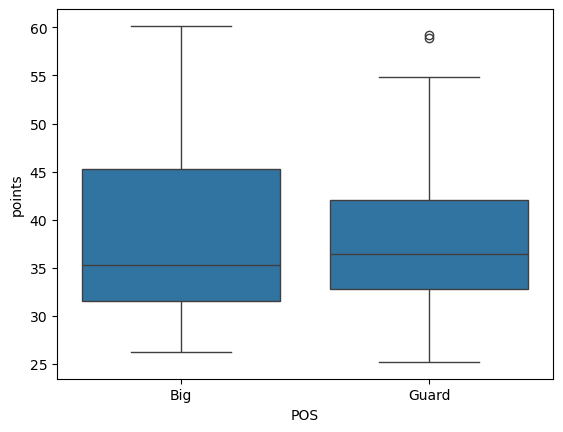

In [20]:
bigs = point_projections[point_projections["POS"].str.contains(r"C|PF")]
guards = point_projections[point_projections["POS"].str.contains(r"SG|PG")]
combined = pd.concat([
    pd.DataFrame({
        "POS": "Big",
        "points": bigs["total"],
    }),
    pd.DataFrame({
        "POS": "Guard",
        "points": guards["total"],
    })
])
sns.boxplot(data=combined, x="POS", y="points")